In [135]:
# Import

# General
import os
import pandas as pd
import numpy as np
import pickle
from collections import Counter
import sys
import copy
import glob

# Import helper functions
from evaluation_helper import *

# Add our pipeline folder to the path to import functions
sys.path.insert(1, '../2_modeling')
from model_helper import *

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import matplotlib.image as mpimg
%matplotlib inline

# Data Processing
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_curve, auc

# Machine Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import backend as K

# List the files of saved models


In [136]:
# Paths
models_path = '../../efs/models'
checkpoint_path='../../efs/models/Checkpoints/'
training_history_path='../../efs/models/Training_history/'
saved_models_path='../../efs/models/Saved_models/'

In [137]:
# Option: List the training history file names
# os.listdir(training_history_path)

In [138]:
def check_number_of_epochs(min_number_of_epochs, path):
    """ check to see if the history has at least a certain number of epochs and for a certain sample size"""    
    
    frame = pd.read_csv(path)
    
    if frame.shape[0] > min_number_of_epochs:
        return True
    
    return False

In [139]:
# Grab all the paths of the csvs
csv_history_paths = glob.glob(training_history_path+'*.csv')

# filter for only that have 'all' samples
csv_history_paths_all = [path for path in csv_history_paths if path.find('all')!=-1]


# Set the minimum number of epochs for models we want to display
minimum_number_of_epochs = 10

# Create a dictionary of dataframes with the name as the key
histories = dict()

for path in csv_history_paths_all:
    try:
        if check_number_of_epochs(minimum_number_of_epochs, path):
            histories[grab_model_name(path)] = pd.read_csv(path)
    except:
        pass

In [140]:
# Create a list of all the dataframes with the correct columns
list_of_dfs = [frame_extraction(histories[path], path) for path in list(histories.keys())]
all_models = pd.concat(list_of_dfs)

In [141]:
# Change all the model names to something comprehensible
old_names = all_models.model.unique()
new_names = ['Single Input with 2 Dense Layers 512 Neurons and 2 open layers',
            'Single Input with 2 Dense Layers 1024 Neurons and 2 open layers',
            'Multiple Input with 2 Dense Layers 1024 Neurons and 2 open layers']

for new,old in zip(new_names, old_names):
    all_models.replace(old, new, inplace=True)

In [142]:
all_models.columns

Index(['epoch', 'val_precision_on_1', 'val_accuracy_on_zero',
       'val_accuracy_on_one', 'model', 'f1'],
      dtype='object')

In [143]:
xlims=-1,15
ylims=0,1

Text(0, 0.5, 'Validation recall on zero')

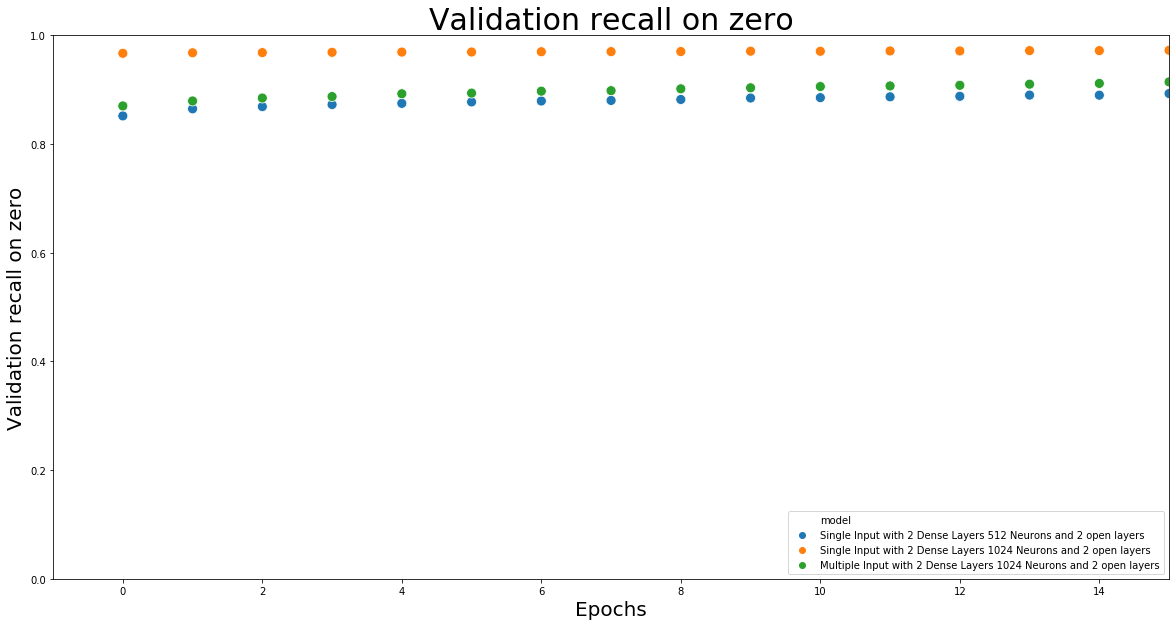

In [144]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(x='epoch', 
                y="val_accuracy_on_zero", 
                hue="model",
                s=100,
                data=all_models, ax=ax)
plt.legend(loc='lower right')
ax.set_xlim(xlims)
ax.set_ylim(ylims)
font_title={'size':30}
plt.title("Validation recall on zero", font_title)
font_axes={'size':20}
ax.set_xlabel("Epochs", font_axes)
ax.set_ylabel("Validation recall on zero", font_axes)

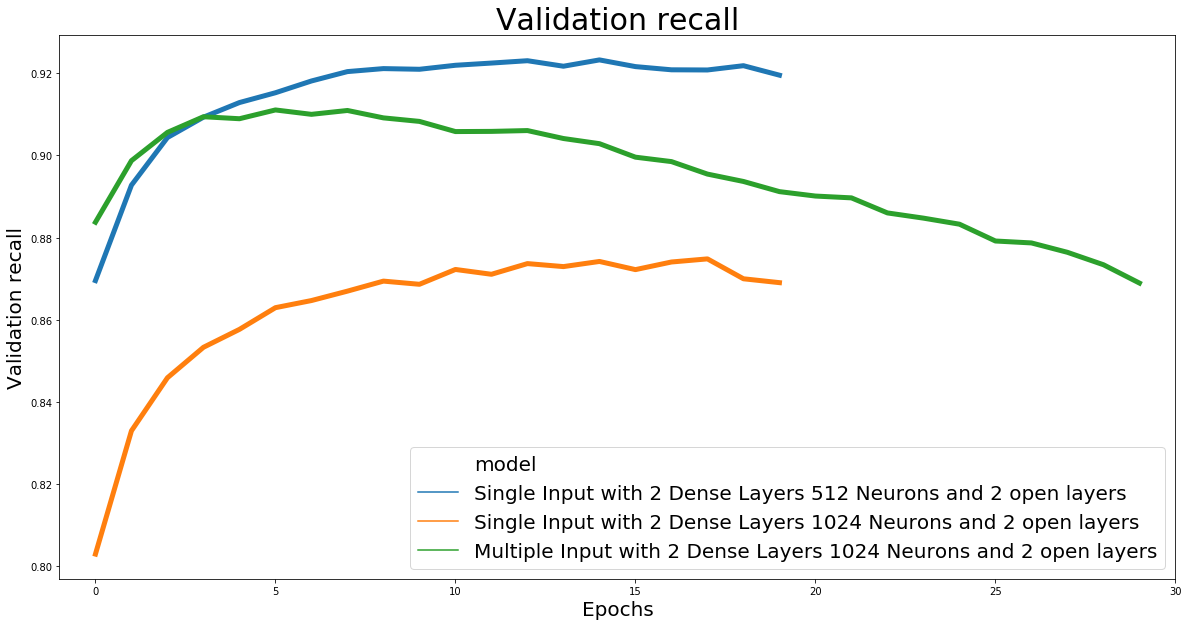

In [145]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x='epoch', y="val_accuracy_on_one", hue="model",
                     data=all_models, ax=ax, lw=5)
ax.set_xlim((-1,30))
plt.title("Validation recall", font_title)
font_axes={'size':20}
ax.set_xlabel("Epochs", font_axes)
ax.set_ylabel("Validation recall", font_axes)
# ax.set_xlim(xlims)
# ax.set_ylim(ylims)
plt.legend(loc='lower right', prop={'size': 20})

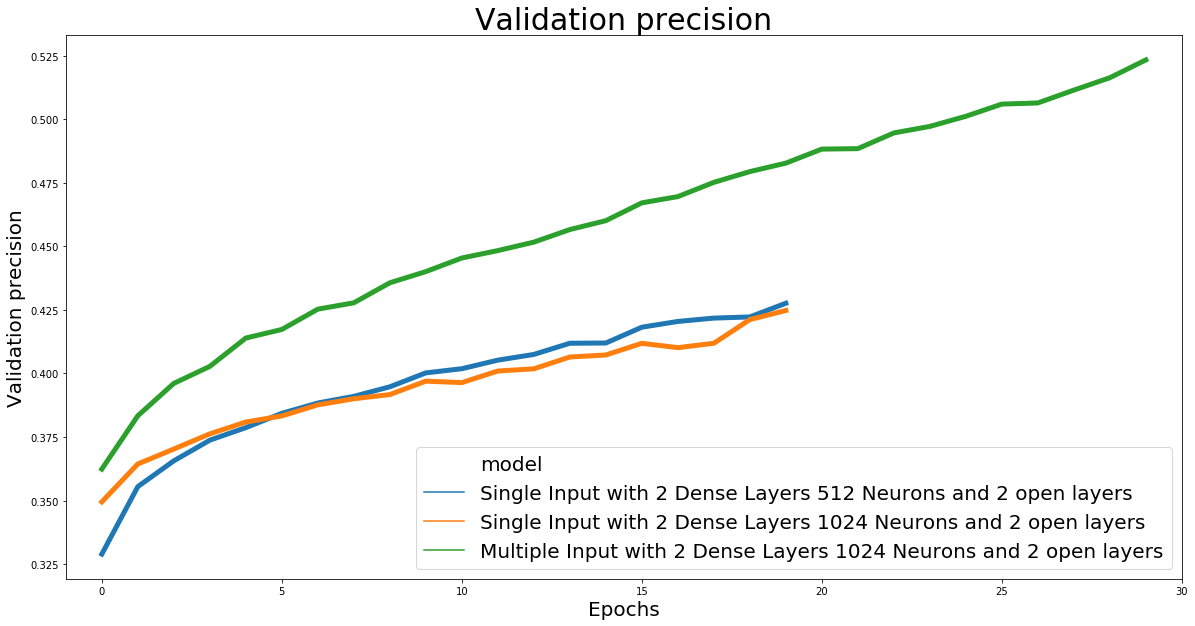

In [146]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x='epoch', y="val_precision_on_1", hue="model",
                     data=all_models, ax=ax, lw=5)

ax.set_xlim((-1,30))

plt.title("Validation precision", font_title)
font_axes={'size':20}
ax.set_xlabel("Epochs", font_axes)
ax.set_ylabel("Validation precision", font_axes)
plt.legend(loc='lower right', prop={'size': 20})
# ax.set_xlim(xlims)
# ax.set_ylim(ylims)

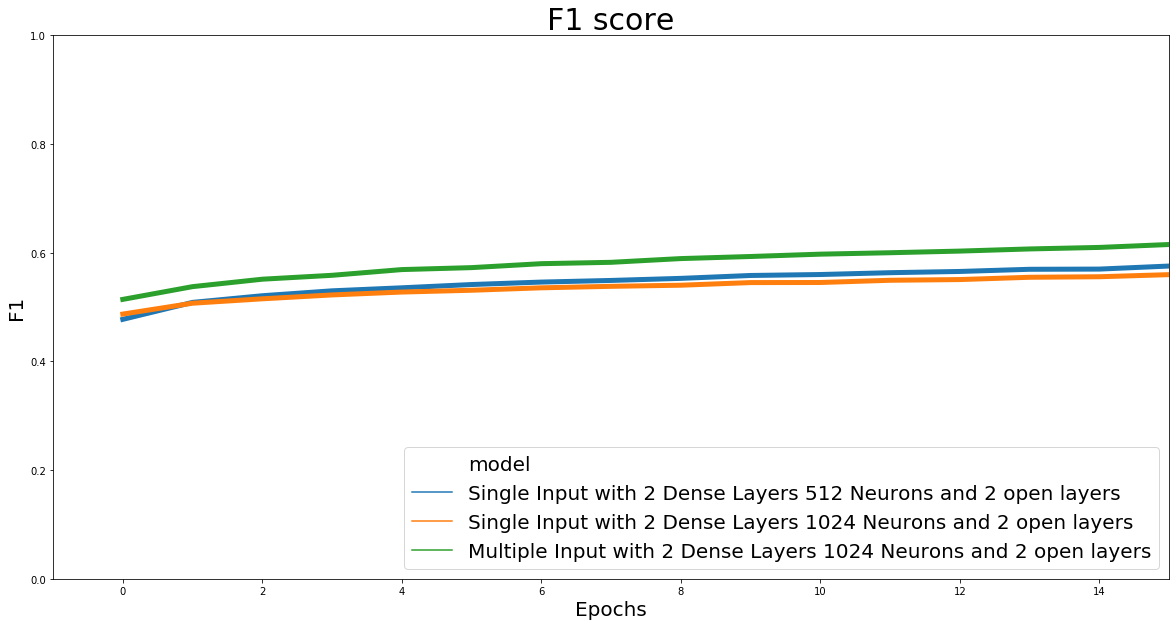

In [148]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x='epoch', 
                y="f1", 
                hue="model",
                lw=5,
                data=all_models, 
                ax=ax)
plt.legend(loc='lower right')
ax.set_xlim((-1,30))
font_title={'size':30}
plt.title("F1 score", font_title)
font_axes={'size':20}
ax.set_xlabel("Epochs", font_axes)
ax.set_ylabel("F1", font_axes)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
plt.legend(loc='lower right', prop={'size': 20})

,epoch,val_precision_on_1,val_accuracy_on_zero,val_accuracy_on_one,model,f1
0,0,0.362379,0.869861,0.883744,Multiple Input with 2 Dense Layers 1024 Neuron...,0.513995
1,1,0.383355,0.878988,0.898732,Multiple Input with 2 Dense Layers 1024 Neuron...,0.537457
2,2,0.396103,0.884420,0.905624,Multiple Input with 2 Dense Layers 1024 Neuron...,0.551145
3,3,0.402790,0.887114,0.909435,Multiple Input with 2 Dense Layers 1024 Neuron...,0.558306
4,4,0.413943,0.892257,0.908950,Multiple Input with 2 Dense Layers 1024 Neuron...,0.568834
5,5,0.417320,0.893487,0.911088,Multiple Input with 2 Dense Layers 1024 Neuron...,0.572437
6,6,0.425316,0.897038,0.910020,Multiple Input with 2 Dense Layers 1024 Neuron...,0.579698
7,7,0.427804,0.897977,0.910960,Multiple Input with 2 Dense Layers 1024 Neuron...,0.582197
8,8,0.435686,0.901388,0.909157,Multiple Input with 2 Dense Layers 1024 Neuron...,0.589076
9,9,0.440090,0.903234,0.908300,Multiple Input with 2 Dense Layers 1024 Neuron...,0.592905


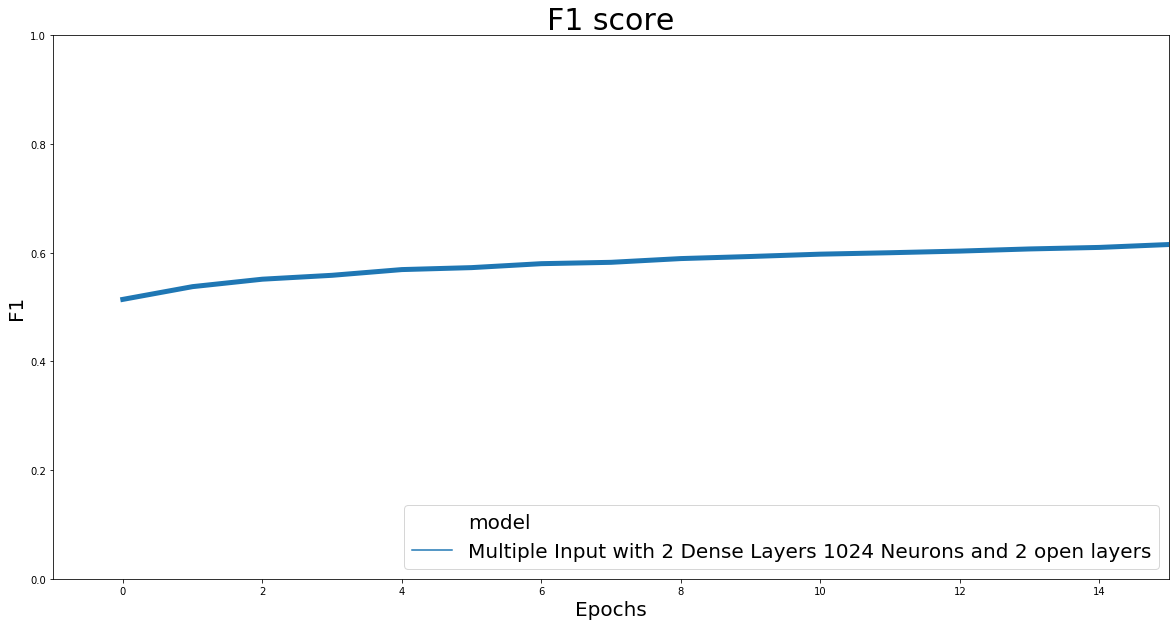

In [156]:
#Only the best model
best = all_models[all_models.model == all_models.model.unique()[2]]

fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x='epoch', 
                y="f1", 
                hue="model",
                lw=5,
                data=best, 
                ax=ax)
plt.legend(loc='lower right')
ax.set_xlim((-1,30))
font_title={'size':30}
plt.title("F1 score", font_title)
font_axes={'size':20}
ax.set_xlabel("Epochs", font_axes)
ax.set_ylabel("F1", font_axes)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
plt.legend(loc='lower right', prop={'size': 20})

In [157]:
best

,epoch,val_precision_on_1,val_accuracy_on_zero,val_accuracy_on_one,model,f1
0,0,0.362379,0.869861,0.883744,Multiple Input with 2 Dense Layers 1024 Neuron...,0.513995
1,1,0.383355,0.878988,0.898732,Multiple Input with 2 Dense Layers 1024 Neuron...,0.537457
2,2,0.396103,0.884420,0.905624,Multiple Input with 2 Dense Layers 1024 Neuron...,0.551145
3,3,0.402790,0.887114,0.909435,Multiple Input with 2 Dense Layers 1024 Neuron...,0.558306
4,4,0.413943,0.892257,0.908950,Multiple Input with 2 Dense Layers 1024 Neuron...,0.568834
5,5,0.417320,0.893487,0.911088,Multiple Input with 2 Dense Layers 1024 Neuron...,0.572437
6,6,0.425316,0.897038,0.910020,Multiple Input with 2 Dense Layers 1024 Neuron...,0.579698
7,7,0.427804,0.897977,0.910960,Multiple Input with 2 Dense Layers 1024 Neuron...,0.582197
8,8,0.435686,0.901388,0.909157,Multiple Input with 2 Dense Layers 1024 Neuron...,0.589076
9,9,0.440090,0.903234,0.908300,Multiple Input with 2 Dense Layers 1024 Neuron...,0.592905
